# Initialize Workspace

In [ ]:
!pip install neurokit2
!pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

# Basic Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from math import floor
import scipy as scipy
import librosa as lbr
import neurokit2 as nk
import pandas as pd
import plotly.express as px
import itertools
import graphviz
import xgboost as xgb
import gc

# Scikit-Learn and Scipy Modules
import seaborn as sns
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from functools import reduce


from scipy.signal import savgol_filter,iirnotch,lfilter,butter,savgol_coeffs,freqz,find_peaks,resample,welch,periodogram,resample_poly,decimate
from scipy import signal
from scipy.stats import linregress, pearsonr, chisquare, chi2
from scipy.signal import firwin, kaiser_atten, kaiser_beta, lfilter,detrend

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM,Conv2D,Conv1D,Bidirectional,Reshape
from keras import backend as K

# ECG Modules
import biosppy

sns.set(font_scale=1.3)
sns.set_style("white")

In [ ]:
# Mount Google Drive
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Set Google Drive Path
libpath = '/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/'

# Import Custom Helper Modules
sys.path.append(libpath+'libs/')

from SQIs import apply_sqi
from pre_processing import data_normalize, up_sampling_data
from generate_dataset import get_dataset_DHMC, get_spirometry_vals
from feature_extractor import get_hand_features
from utilities import get_per_subject_data, edr_neurokit

In [ ]:
# Useful directories
datapath_dir = '/content/drive/My Drive/HeartFEV1 Project/Data/DHMC_Data/dataset/'
saved_models = '/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/'

In [ ]:
# Initialize Variables
Fs_ppg = 54
Fs_resp = 20
Fs_ecg = 300
Fs_ppg_up = 60

# Trained model to generate pulse wave from peaks and valleys
model_classifier_ecg_board = tf.keras.models.load_model(saved_models+'221030_210932.h5')

In [ ]:
def data_preprocess(ECG_data,RESP_data,PPG_data,fev1_in,fvc_in,bmi_in,subjects_in,fs_resp,fs_ecg,PPG_input=False):
  # Normalize and up-sample PPG
  PPG_data_bw_90 = up_sampling_data(PPG_data.reshape(PPG_data.shape[0],PPG_data.shape[1],1),RESP_data.shape[1]*3)
  PPG_in = data_normalize(PPG_data_bw_90)
  RESP_in = data_normalize(RESP_data.reshape(RESP_data.shape[0],RESP_data.shape[1],1))
  ECG_in = data_normalize(ECG_data.reshape(ECG_data.shape[0],ECG_data.shape[1],1))

  # Apply SQI
  bd_windows = apply_sqi(RESP_in,ECG_in,fs_resp,fs_ecg,PPG_input)
  print(bd_windows)
  # Remove bad data
  ECG_dhmc = np.delete(ECG_in,bd_windows,0)
  if PPG_input:
    PPG_dhmc = np.delete(PPG_in,bd_windows,0)
  else:
    PPG_dhmc = PPG_in
  RESP_dhmc = np.delete(RESP_in,bd_windows,0)
  subjects_left_dhmc = np.delete(subjects_in,bd_windows,0)
  fev1_dhmc = np.delete(fev1_in,bd_windows,0)
  fvc_dhmc = np.delete(fvc_in,bd_windows,0)
  bmi_dhmc = np.delete(bmi_in,bd_windows,0)
  return ECG_dhmc,PPG_dhmc,RESP_dhmc,subjects_left_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc

In [ ]:
def summarize_features(x_test_feat):
  feature_names = ['IER_med','RR_med','TA_med','S_med','SE_med','DFA_med','IRA_med','ERA_med', 'EA1_med',
          'IER_rms','RR_rms','TA_rms','S_rms','SE_rms','DFA_rms','IRA_rms','ERA_rms', 'EA1_rms',
          'IER_var','RR_var','TA_var','S_var','SE_var','DFA_var','IRA_var','ERA_var', 'EA1_var']
  x_test_feat_new_med,y_test_class_new,y_test_fvc_new, y_test_bmi_new, y_test_subjects_new = get_per_subject_data(x_test_feat,y_test,y_test_fvc,y_test_bmi,y_test_subjects)
  x_test_feat_new_rms,_,_,_,_ = get_per_subject_data(x_test_feat,y_test,y_test_fvc,y_test_bmi,y_test_subjects,'RMS')
  x_test_feat_new_var,_,_,_,_ = get_per_subject_data(x_test_feat,y_test,y_test_fvc,y_test_bmi,y_test_subjects,'var')
  x_test_feat_new = np.concatenate((x_test_feat_new_med,x_test_feat_new_rms,x_test_feat_new_var),axis=1)
  return x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,feature_names


In [ ]:
# Compute correlation
def fev1_fvc_correlation(features_in,fev1_vals,fvc_vals):
  data_in = np.concatenate((fev1_vals.reshape(fev1_vals.shape[0],1),features_in),axis=1)
  y_d_dhmc_fev1 = pd.DataFrame(data_in, columns=['FEV1']+cols_N)
  data_in = np.concatenate((fvc_vals.reshape(fvc_vals.shape[0],1),features_in),axis=1)
  y_d_dhmc_fvc = pd.DataFrame(data_in, columns=['FVC']+cols_N)
  y_d_fev1 = pd.concat([abs(y_d_dhmc_fev1.corr().iloc[0,1:]),abs(y_d_dhmc_fvc.corr().iloc[0,1:])],axis=1,keys=['FEV1','FVC'])
  y_d_fev1.plot.bar(figsize=[10,4],ylim=[0,1.0])
  plt.ylabel('abs(r)')
  plt.xlabel('Respiratory Features')
  plt.title('Correlation between FEV1,FVC and respiratory features')
  plt.grid()
  plt.show()
  return

In [ ]:
# Select 7 best features
def select_n_best_features(features_in,lung_func_param,subjects_in,num_feats=6):
  start_update = 0
  idxs_gd=[]
  while start_update <= num_feats:
    best_r2 = 0.0
    best_feat = []
    for idxs_in in [x for x in range(features_in.shape[1]) if x not in idxs_gd]:
      idxs = [idxs_in]
      x_test_feat_new_idx = features_in[:,idxs]
      unique_test_subjs = np.unique(subjects_in)
      y_predicted = np.zeros_like(lung_func_param)
      y_true =  lung_func_param

      # Perform Manual Leave-One Out
      for m in range(len(unique_test_subjs)):
        test_subj = unique_test_subjs[m]
        # print('m = ',m+1,' of ',len(unique_test_subjs),', subj = ',test_subj)
        idx_test_subj = np.argwhere(subjects_in==test_subj)[:,0]
        idx_nottest_subj = np.argwhere(subjects_in!=test_subj)[:,0]
        x_train = x_test_feat_new_idx[idx_nottest_subj]
        x_test = x_test_feat_new_idx[idx_test_subj]
        y_train_model = lung_func_param[idx_nottest_subj]
        y_test_model = lung_func_param[idx_test_subj]
        scaler = StandardScaler().fit(x_train)
        x_train_norm = scaler.transform(x_train)
        x_test_norm = scaler.transform(x_test)
        model = tree.DecisionTreeRegressor(random_state=3)
        model.fit(x_train_norm, y_train_model)
        y_predicted[idx_test_subj] = model.predict(x_test_norm)

      slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_predicted)
      r_sq_rr = r_rr**2
      # Percent error
      percent_error = np.mean(100*abs((y_predicted-y_true)/y_true))
      if r_rr > best_r2:
        best_r2 = r_rr
        best_feat = idxs

    idxs_gd = idxs_gd + best_feat
    start_update += 1
  return idxs_gd

In [ ]:
# Select best feature combination
def select_best_combination(features_in,lung_func_param,subjects_in,idxs_gd):
  best_r2 = 0.0
  best_feat = []
  for z in range(2,len(idxs_gd)):
    perm_r = itertools.combinations(idxs_gd, z)
    v_l = list(perm_r)
    for w in range(len(v_l)):
      idxs = v_l[w]
      x_test_feat_new_idx = features_in[:,idxs]
      unique_test_subjs = np.unique(subjects_in)
      y_predicted = np.zeros_like(lung_func_param)
      y_true =  lung_func_param

      # Perform Manual Leave-One Out
      for m in range(len(unique_test_subjs)):
        test_subj = unique_test_subjs[m]
        # print('m = ',m+1,' of ',len(unique_test_subjs),', subj = ',test_subj)
        idx_test_subj = np.argwhere(subjects_in==test_subj)[:,0]
        idx_nottest_subj = np.argwhere(subjects_in!=test_subj)[:,0]
        x_train = x_test_feat_new_idx[idx_nottest_subj]
        x_test = x_test_feat_new_idx[idx_test_subj]
        y_train_model = lung_func_param[idx_nottest_subj]
        y_test_model = lung_func_param[idx_test_subj]
        scaler = StandardScaler().fit(x_train)
        x_train_norm = scaler.transform(x_train)
        x_test_norm = scaler.transform(x_test)
        model = tree.DecisionTreeRegressor(random_state=3)
        model.fit(x_train_norm, y_train_model)
        y_predicted[idx_test_subj] = model.predict(x_test_norm)

      slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_predicted)
      r_sq_rr = r_rr**2
      # Percent error
      percent_error = np.mean(100*abs((y_predicted-y_true)/y_true))
      if r_rr > best_r2:
        best_r2 = r_rr
        best_feat = idxs
  return best_feat

In [ ]:
def feature_selection(features_in,lung_func_param,subjects_in):
  n_features = select_n_best_features(features_in,lung_func_param,subjects_in)
  features_selected = select_best_combination(features_in,lung_func_param,subjects_in,n_features)
  return features_selected

In [ ]:
def model_train_eval(features_in,lung_func_param,subjects_in,selected_feats):
  x_test_feat_new_idx = features_in[:,selected_feats]
  unique_test_subjs = np.unique(subjects_in)
  y_predicted = np.zeros_like(lung_func_param)
  y_true =  lung_func_param
  feat_importances = np.zeros((len(unique_test_subjs),x_test_feat_new_idx.shape[1]))
  # Perform Manual Leave-One Out
  for m in range(len(unique_test_subjs)):
    test_subj = unique_test_subjs[m]
    #print('m = ',m+1,' of ',len(unique_test_subjs),', subj = ',test_subj)
    idx_test_subj = np.argwhere(subjects_in==test_subj)[:,0]
    idx_nottest_subj = np.argwhere(subjects_in!=test_subj)[:,0]
    x_train = x_test_feat_new_idx[idx_nottest_subj]
    x_test = x_test_feat_new_idx[idx_test_subj]
    y_train_model = lung_func_param[idx_nottest_subj]
    y_test_model = lung_func_param[idx_test_subj]
    scaler = StandardScaler().fit(x_train)
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)
    model = tree.DecisionTreeRegressor(random_state=3)
    model.fit(x_train_norm, y_train_model)
    y_predicted[idx_test_subj] = model.predict(x_test_norm)
    feat_importances[m,:] = model.feature_importances_
  return y_true,y_predicted,feat_importances

In [ ]:
# Performance Metrics
def performance_visualize(y_true,y_pred,feat_importances,selected_feats,feature_names,feat):
  # Feature Importance
  feat_avg = np.mean(feat_importances,axis=0,keepdims=True)
  feat_import = np.concatenate((feat_importances,feat_avg),axis=0)
  df_feat_import = pd.DataFrame(np.round(feat_import,2), columns=[feature_names[m] for m in selected_feats])
  ax = df_feat_import.iloc[15].plot.bar(figsize=[4,4],ylim=[0,1.0])
  for container in ax.containers:
      ax.bar_label(container)
  plt.grid('on')
  plt.title(feat)
  plt.ylabel('Feature Importance')
  plt.xlabel('Selected Feature Combination')
  plt.show()
  # Prediction Performance
  slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_pred)
  r_sq_rr = r_rr**2
  # Percent error
  percent_error = np.mean(100*abs((y_pred-y_true)/y_true))
  print('Percentage error = ',np.round(percent_error,2),'%')
  plt.plot(y_true,y_pred,'*')
  plt.xlabel('True '+feat)
  plt.ylabel('Predicted '+feat)
  plt.title('r = '+str(np.round(r_rr,2))+', R^2 = '+str(np.round(r_sq_rr,2))+', mape = '+str(np.round(percent_error,2))+'%')
  plt.show()
  return

# Load DHMC Dataset

In [ ]:
ECG_data,RESP_data,_,subjects_dhmc = get_dataset_DHMC()
ECG_data_ppg,RESP_data_ppg,PPG_data,subjects_dhmc_ppg = get_dataset_DHMC(True)

print(ECG_data.shape, RESP_data.shape, len(subjects_dhmc))
print(ECG_data_ppg.shape, RESP_data_ppg.shape,PPG_data.shape,len(subjects_dhmc_ppg))

(148, 27000) (148, 1800) 148
(121, 27000) (121, 1800) (121, 4860) 121


In [ ]:
fev1,fvc,bmi = get_spirometry_vals(subjects_dhmc)
fev1_ppg,fvc_ppg,bmi_ppg = get_spirometry_vals(subjects_dhmc_ppg)
print(fev1.shape,fvc.shape,bmi.shape)
print(fev1_ppg.shape,fvc_ppg.shape,bmi_ppg.shape)

(148,) (148,) (148,)
(121,) (121,) (121,)


# Data Pre-processing

In [ ]:
ECG_dhmc,_,RESP_dhmc,subjects_left_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc = data_preprocess(ECG_data,RESP_data,PPG_data,fev1,fvc,bmi,subjects_dhmc,Fs_resp,Fs_ecg,False)
print(len(subjects_left_dhmc),ECG_dhmc.shape,RESP_dhmc.shape,fev1_dhmc.shape,fvc_dhmc.shape,bmi_dhmc.shape,len(np.unique(subjects_left_dhmc)), len(np.unique(subjects_dhmc)))

[  7   8   9  16  22  24  25  26  27  30  33  37  45  52  80  82  85  93
  94  95  96 100 109 118 119 120 121 122 125 139 141]
[  7   8  28  34  35  36  37  38  39  46  52  55  64  77  78  91  92  93
  94  95  96  99 100 106 108 109 134]
[  7   8   9  16  22  24  25  26  27  28  30  33  34  35  36  37  38  39
  45  46  52  55  64  77  78  80  82  85  91  92  93  94  95  96  99 100
 106 108 109 118 119 120 121 122 125 134 139 141]
100 (100, 27000, 1) (100, 1800, 1) (100,) (100,) (100,) 24 25


In [ ]:
_,PPG_dhmc,_,subjects_left_dhmc_ppg,fev1_dhmc_ppg,fvc_dhmc_ppg,bmi_dhmc_ppg = data_preprocess(ECG_data_ppg,RESP_data_ppg,PPG_data,fev1_ppg,fvc_ppg,bmi_ppg,subjects_dhmc_ppg,Fs_resp,Fs_ecg,True)
print(len(subjects_left_dhmc_ppg),PPG_dhmc.shape,fev1_dhmc_ppg.shape,fvc_dhmc_ppg.shape,bmi_dhmc_ppg.shape,len(np.unique(subjects_left_dhmc_ppg)), len(np.unique(subjects_dhmc)))

[  6   7   8  20  21  22  23  25  28  31  38  68  70  76  77  78  81  89
  96  97  98  99 102 113 115]
[  6   7   8  20  21  22  23  24  25  28  29  30  31  32  33  38  44  45
  54  59  60  61  64  65  68  70  75  76  77  78  81  89  96  97  98  99
 102 113 115]
82 (82, 5400, 1) (82,) (82,) (82,) 24 25


In [ ]:
# Extract EDR and PDR signals
# EDR Model
x_input = layers.Input(shape=(None,1),name='inputs')
# CNN Layers
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# GRU Layer
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting
model = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=adam, loss={'regression':'mse'})
model.load_weights(saved_models+'worst_case_240207_200203.hdf5') #
model.compile(optimizer=adam, loss={'regression':'mse'})
EDR_in = model.predict({'inputs':data_normalize(ECG_dhmc)})
EDR_dhmc = data_normalize(EDR_in)

# PDR Model
x_input = layers.Input(shape=(None,1),name='inputs')
# CNN Layers
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=1,activation='relu')(cnn1)
# GRU Layer
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting
model = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=adam, loss={'regression':'mse'})
model.load_weights(saved_models+'ppg_worst_case_240213_175304.hdf5') #
model.compile(optimizer=adam, loss={'regression':'mse'})
PDR_in = model.predict({'inputs':data_normalize(PPG_dhmc)})
PDR_dhmc = data_normalize(PDR_in)

3/3 [==============================] - 2s 323ms/step


In [ ]:
EDR_in = edr_neurokit(data_normalize(ECG_dhmc),RESP_dhmc,method="charlton2016")
EDR_charlton = data_normalize(EDR_in)

EDR_in = edr_neurokit(data_normalize(ECG_dhmc),RESP_dhmc,method="vangent2019")
EDR_vangent = data_normalize(EDR_in)

EDR_in = edr_neurokit(data_normalize(ECG_dhmc),RESP_dhmc,method="soni2019")
EDR_soni = data_normalize(EDR_in)

# Respiratory Signal

In [ ]:
# Define Data
x_test,y_test,y_test_fvc,y_test_bmi,y_test_subjects = data_normalize(RESP_dhmc),fev1_dhmc,fvc_dhmc,bmi_dhmc,subjects_left_dhmc
sq_pr1 = model_classifier_ecg_board.predict(data_normalize(x_test))
x_test_class = sq_pr1.round()

4/4 [==============================] - 1s 160ms/step


In [ ]:
# Get hand engineered features
x_test_handfeat = get_hand_features(x_test, x_test_class,y_test_bmi,Fs_resp)
# Summarization step - per subject
x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,cols_N = summarize_features(x_test_handfeat)
print(x_test_feat_new.shape,y_test_class_new.shape,y_test_fvc_new.shape,y_test_bmi_new.shape,y_test_subjects_new.shape)

(24, 27) (24,) (24,) (24,) (24,)


## Visualize feature correlations

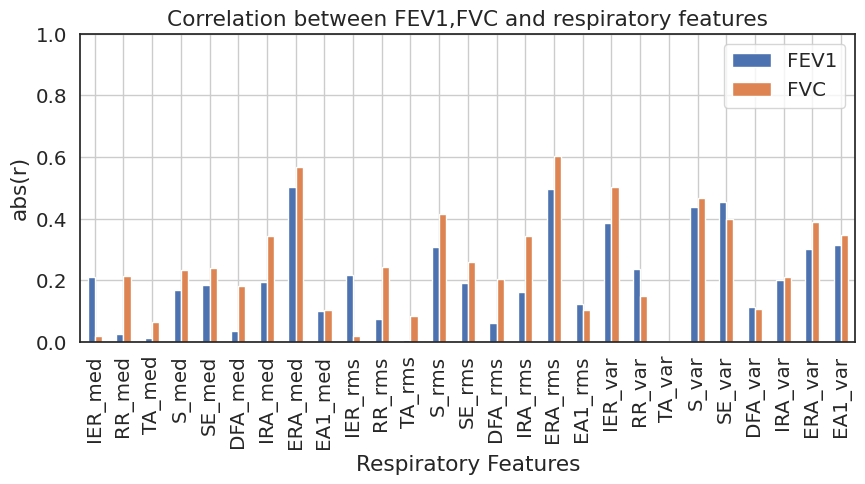

In [ ]:
fev1_fvc_correlation(x_test_feat_new,y_test_class_new,y_test_fvc_new)

## Model Selection

In [ ]:
fev1_features = feature_selection(x_test_feat_new,y_test_class_new,y_test_subjects_new)
fvc_features = feature_selection(x_test_feat_new,y_test_fvc_new,y_test_subjects_new)
print(fev1_features, fvc_features)

(15, 7, 0) (26, 16, 7)


In [ ]:
print('FEV1 Feature Combination:', [cols_N[m] for m in fev1_features])
print('FVC Feature Combination:', [cols_N[m] for m in fvc_features])

FEV1 Feature Combination: ['IRA_rms', 'ERA_med', 'IER_med']
FVC Feature Combination: ['EA1_var', 'ERA_rms', 'ERA_med']


## Model Training and LOSO Evaluation

In [ ]:
# FEV1 Performance
y_true_fev1,y_predicted_fev1,feat_importances_fev1 = model_train_eval(x_test_feat_new,y_test_class_new,y_test_subjects_new,fev1_features)
# FVC Performance
y_true_fvc,y_predicted_fvc,feat_importances_fvc = model_train_eval(x_test_feat_new,y_test_fvc_new,y_test_subjects_new,fvc_features)

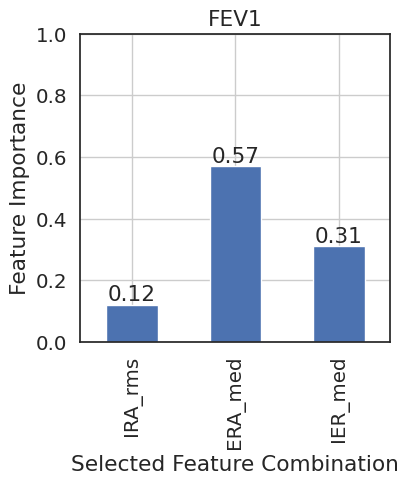

Percentage error =  24.67 %


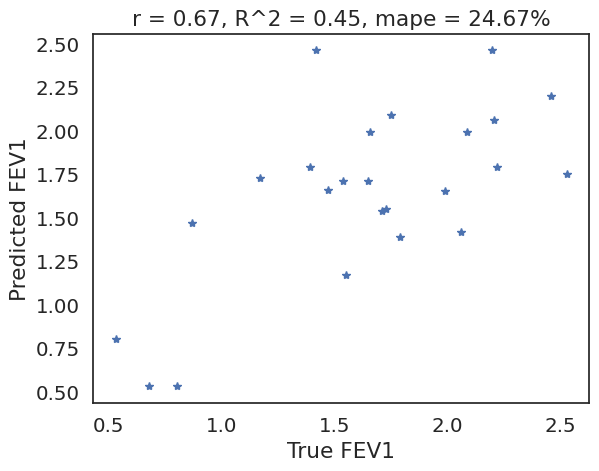

In [ ]:
performance_visualize(y_true_fev1,y_predicted_fev1,feat_importances_fev1,fev1_features,cols_N,'FEV1')

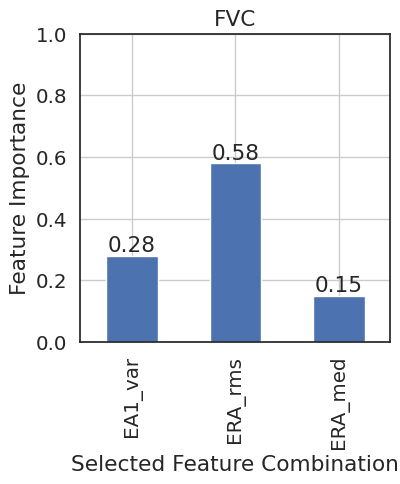

Percentage error =  26.89 %


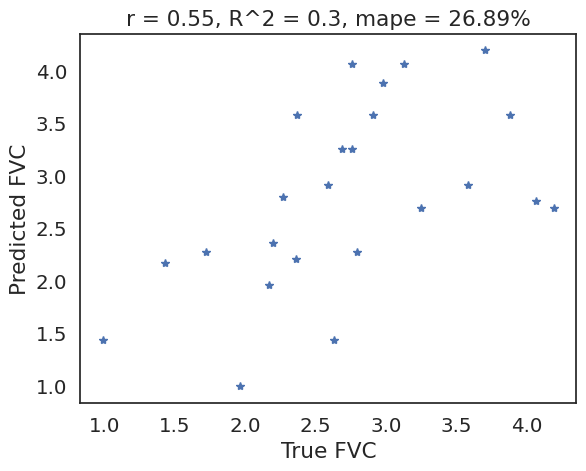

In [ ]:
performance_visualize(y_true_fvc,y_predicted_fvc,feat_importances_fvc,fvc_features,cols_N,'FVC')

# PPG-Derived Respiratory Signal

In [ ]:
# Define Data
x_test,y_test,y_test_fvc,y_test_bmi,y_test_subjects = PDR_dhmc,fev1_dhmc_ppg,fvc_dhmc_ppg,bmi_dhmc_ppg,subjects_left_dhmc_ppg
sq_pr1 = model_classifier_ecg_board.predict(data_normalize(x_test))
x_test_class = sq_pr1.round()

3/3 [==============================] - 1s 160ms/step


In [ ]:
# Get hand engineered features
x_test_handfeat = get_hand_features(x_test, x_test_class,y_test_bmi,Fs_resp)
# Summarization step - per subject
x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,cols_N = summarize_features(x_test_handfeat)
print(x_test_feat_new.shape,y_test_class_new.shape,y_test_fvc_new.shape,y_test_bmi_new.shape,y_test_subjects_new.shape)

(24, 27) (24,) (24,) (24,) (24,)


## Visualize feature correlations

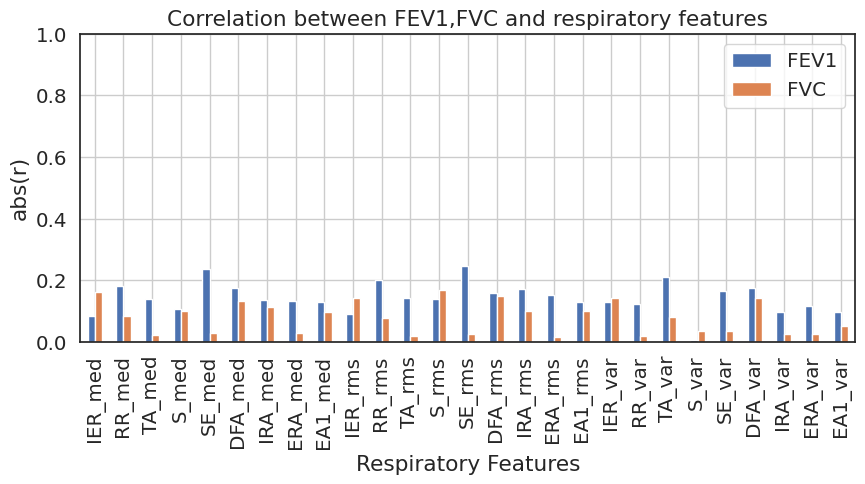

In [ ]:
fev1_fvc_correlation(x_test_feat_new,y_test_class_new,y_test_fvc_new)

## Model Selection

In [ ]:
fev1_features = feature_selection(x_test_feat_new,y_test_class_new,y_test_subjects_new)
fvc_features = feature_selection(x_test_feat_new,y_test_fvc_new,y_test_subjects_new)
print(fev1_features, fvc_features)

(11, 2) (22, 5)


In [ ]:
print('FEV1 Feature Combination:', [cols_N[m] for m in fev1_features])
print('FVC Feature Combination:', [cols_N[m] for m in fvc_features])

FEV1 Feature Combination: ['TA_rms', 'TA_med']
FVC Feature Combination: ['SE_var', 'DFA_med']


## Model Training and LOSO Evaluation

In [ ]:
# FEV1 Performance
y_true_fev1,y_predicted_fev1,feat_importances_fev1 = model_train_eval(x_test_feat_new,y_test_class_new,y_test_subjects_new,fev1_features)
# FVC Performance
y_true_fvc,y_predicted_fvc,feat_importances_fvc = model_train_eval(x_test_feat_new,y_test_fvc_new,y_test_subjects_new,fvc_features)

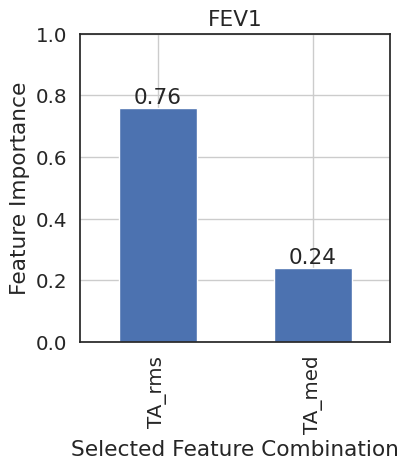

Percentage error =  32.42 %


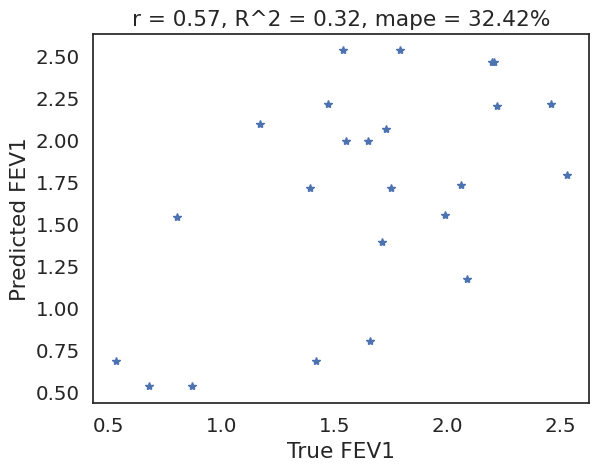

In [ ]:
performance_visualize(y_true_fev1,y_predicted_fev1,feat_importances_fev1,fev1_features,cols_N,'FEV1')

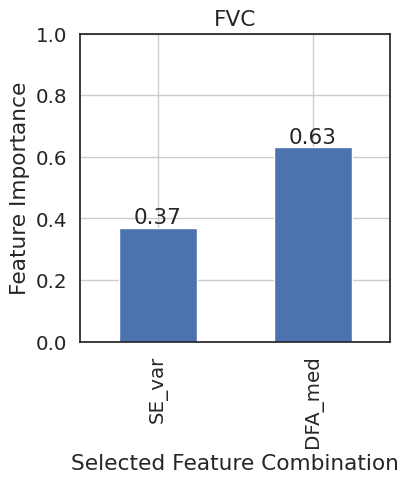

Percentage error =  35.83 %


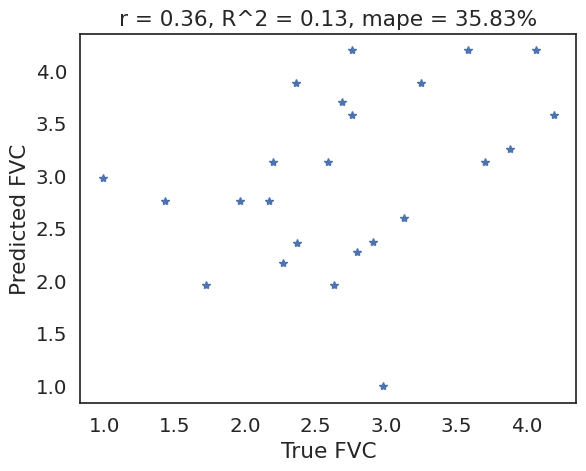

In [ ]:
performance_visualize(y_true_fvc,y_predicted_fvc,feat_importances_fvc,fvc_features,cols_N,'FVC')

# ECG-Derived Respiratory Signal

In [ ]:
# Define Data
x_test,y_test,y_test_fvc,y_test_bmi,y_test_subjects = EDR_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc,subjects_left_dhmc
sq_pr1 = model_classifier_ecg_board.predict(data_normalize(x_test))
x_test_class = sq_pr1.round()

4/4 [==============================] - 1s 219ms/step


In [ ]:
# Get hand engineered features
x_test_handfeat = get_hand_features(x_test, x_test_class,y_test_bmi,Fs_resp)
x_test_handfeat = np.nan_to_num(x_test_handfeat,nan=0,posinf=None,neginf=None)
# Summarization step - per subject
x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,cols_N = summarize_features(x_test_handfeat)
print(x_test_feat_new.shape,y_test_class_new.shape,y_test_fvc_new.shape,y_test_bmi_new.shape,y_test_subjects_new.shape)

(24, 27) (24,) (24,) (24,) (24,)


## Visualize feature correlations

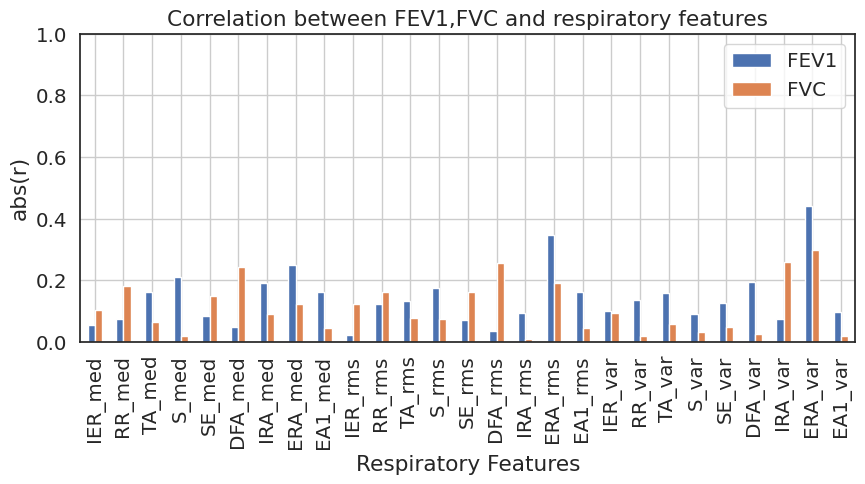

In [ ]:
fev1_fvc_correlation(x_test_feat_new,y_test_class_new,y_test_fvc_new)

## Model Selection

In [ ]:
fev1_features = feature_selection(x_test_feat_new,y_test_class_new,y_test_subjects_new)
fvc_features = feature_selection(x_test_feat_new,y_test_fvc_new,y_test_subjects_new)
print(fev1_features, fvc_features)

(12, 3, 20) (0, 13, 12, 3)


In [ ]:
print('FEV1 Feature Combination:', [cols_N[m] for m in fev1_features])
print('FVC Feature Combination:', [cols_N[m] for m in fvc_features])

FEV1 Feature Combination: ['S_rms', 'S_med', 'TA_var']
FVC Feature Combination: ['IER_med', 'SE_rms', 'S_rms', 'S_med']


## Model Training and LOSO Evaluation

In [ ]:
# FEV1 Performance
y_true_fev1,y_predicted_fev1,feat_importances_fev1 = model_train_eval(x_test_feat_new,y_test_class_new,y_test_subjects_new,fev1_features)
# FVC Performance
y_true_fvc,y_predicted_fvc,feat_importances_fvc = model_train_eval(x_test_feat_new,y_test_fvc_new,y_test_subjects_new,fvc_features)

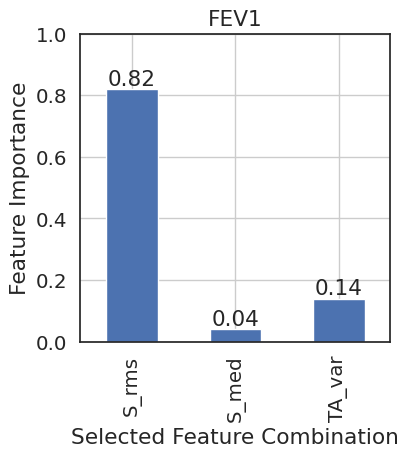

Percentage error =  25.16 %


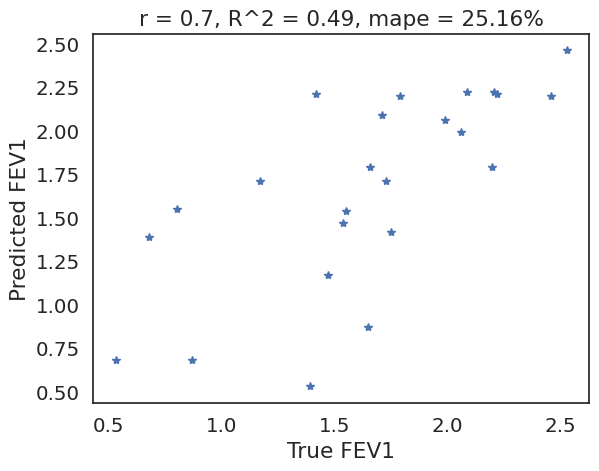

In [ ]:
performance_visualize(y_true_fev1,y_predicted_fev1,feat_importances_fev1,fev1_features,cols_N,'FEV1')

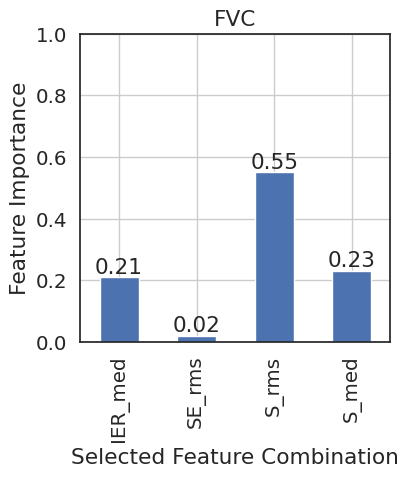

Percentage error =  31.71 %


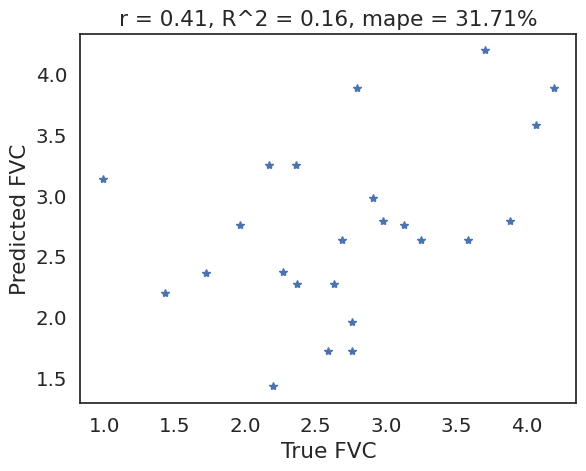

In [ ]:
performance_visualize(y_true_fvc,y_predicted_fvc,feat_importances_fvc,fvc_features,cols_N,'FVC')

# Charlton - EDR

In [ ]:
# Define Data
x_test,y_test,y_test_fvc,y_test_bmi,y_test_subjects = EDR_charlton,fev1_dhmc,fvc_dhmc,bmi_dhmc,subjects_left_dhmc
sq_pr1 = model_classifier_ecg_board.predict(data_normalize(x_test))
x_test_class = sq_pr1.round()

4/4 [==============================] - 1s 165ms/step


In [ ]:
# Get hand engineered features
x_test_handfeat = get_hand_features(x_test, x_test_class,y_test_bmi,Fs_resp)
x_test_handfeat = np.nan_to_num(x_test_handfeat,nan=0,posinf=None,neginf=None)
# Summarization step - per subject
x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,cols_N = summarize_features(x_test_handfeat)
print(x_test_feat_new.shape,y_test_class_new.shape,y_test_fvc_new.shape,y_test_bmi_new.shape,y_test_subjects_new.shape)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(24, 27) (24,) (24,) (24,) (24,)


## Visualize feature correlations

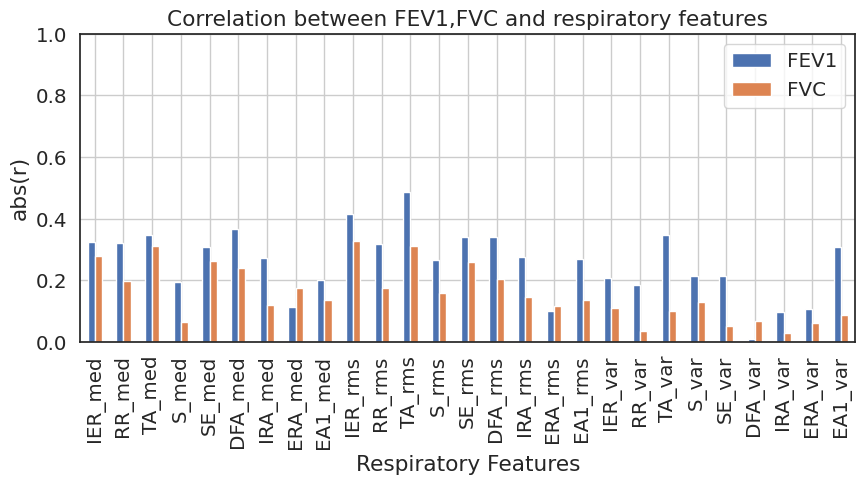

In [ ]:
fev1_fvc_correlation(x_test_feat_new,y_test_class_new,y_test_fvc_new)

## Model Selection

In [ ]:
fev1_features = feature_selection(x_test_feat_new,y_test_class_new,y_test_subjects_new)
fvc_features = feature_selection(x_test_feat_new,y_test_fvc_new,y_test_subjects_new)
print(fev1_features, fvc_features)

(18, 6) (3, 18)


In [ ]:
print('FEV1 Feature Combination:', [cols_N[m] for m in fev1_features])
print('FVC Feature Combination:', [cols_N[m] for m in fvc_features])

FEV1 Feature Combination: ['IER_var', 'IRA_med']
FVC Feature Combination: ['S_med', 'IER_var']


## Model Training and LOSO Evaluation

In [ ]:
# FEV1 Performance
y_true_fev1,y_predicted_fev1,feat_importances_fev1 = model_train_eval(x_test_feat_new,y_test_class_new,y_test_subjects_new,fev1_features)
# FVC Performance
y_true_fvc,y_predicted_fvc,feat_importances_fvc = model_train_eval(x_test_feat_new,y_test_fvc_new,y_test_subjects_new,fvc_features)

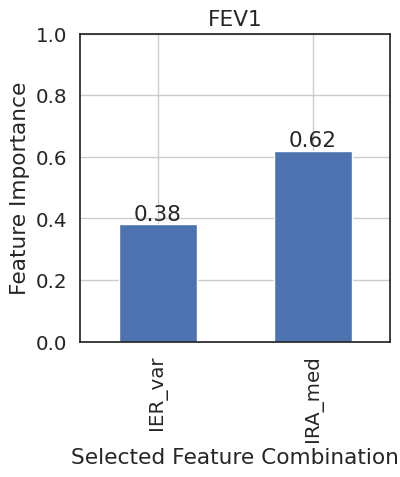

Percentage error =  30.21 %


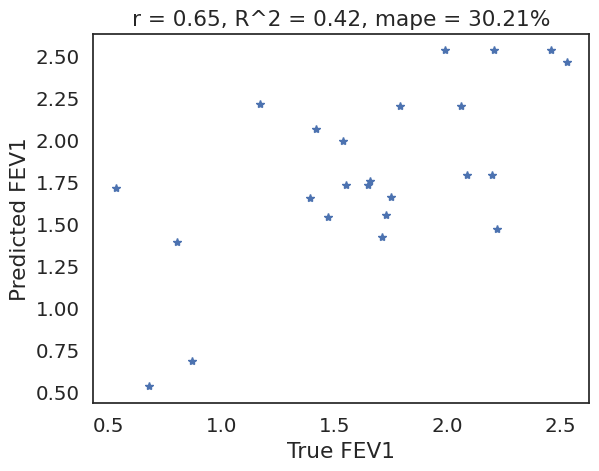

In [ ]:
performance_visualize(y_true_fev1,y_predicted_fev1,feat_importances_fev1,fev1_features,cols_N,'FEV1')

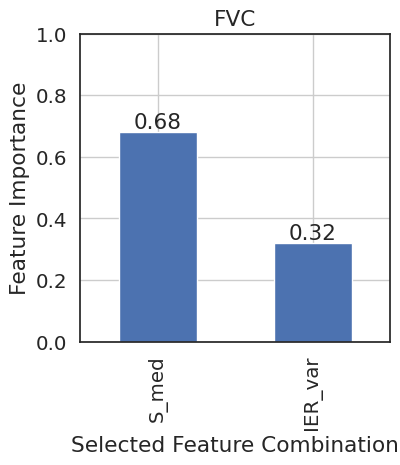

Percentage error =  33.95 %


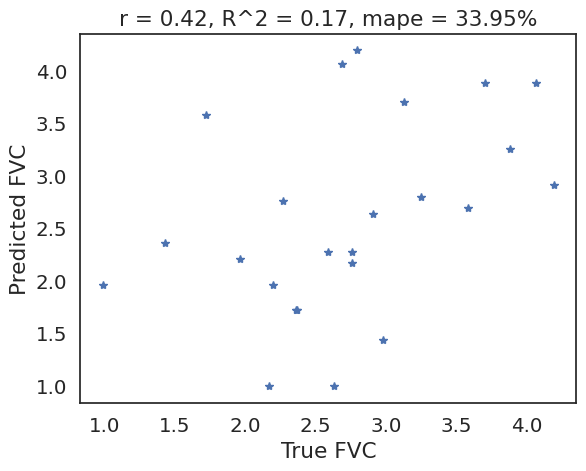

In [ ]:
performance_visualize(y_true_fvc,y_predicted_fvc,feat_importances_fvc,fvc_features,cols_N,'FVC')

# van Gent - EDR

In [ ]:
# Define Data
x_test,y_test,y_test_fvc,y_test_bmi,y_test_subjects = EDR_vangent,fev1_dhmc,fvc_dhmc,bmi_dhmc,subjects_left_dhmc
sq_pr1 = model_classifier_ecg_board.predict(data_normalize(x_test))
x_test_class = sq_pr1.round()

4/4 [==============================] - 1s 166ms/step


In [ ]:
# Get hand engineered features
x_test_handfeat = get_hand_features(x_test, x_test_class,y_test_bmi,Fs_resp)
x_test_handfeat = np.nan_to_num(x_test_handfeat,nan=0,posinf=None,neginf=None)
# Summarization step - per subject
x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,cols_N = summarize_features(x_test_handfeat)
print(x_test_feat_new.shape,y_test_class_new.shape,y_test_fvc_new.shape,y_test_bmi_new.shape,y_test_subjects_new.shape)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(24, 27) (24,) (24,) (24,) (24,)


## Visualize feature correlations

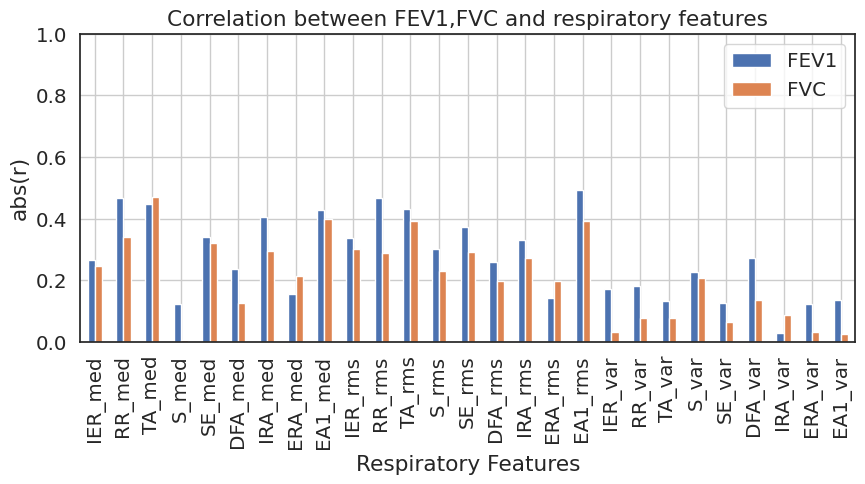

In [ ]:
fev1_fvc_correlation(x_test_feat_new,y_test_class_new,y_test_fvc_new)

## Model Selection

In [ ]:
fev1_features = feature_selection(x_test_feat_new,y_test_class_new,y_test_subjects_new)
fvc_features = feature_selection(x_test_feat_new,y_test_fvc_new,y_test_subjects_new)
print(fev1_features, fvc_features)

(15, 9, 4, 17) (17, 22)


In [ ]:
print('FEV1 Feature Combination:', [cols_N[m] for m in fev1_features])
print('FVC Feature Combination:', [cols_N[m] for m in fvc_features])

FEV1 Feature Combination: ['IRA_rms', 'IER_rms', 'SE_med', 'EA1_rms']
FVC Feature Combination: ['EA1_rms', 'SE_var']


## Model Training and LOSO Evaluation

In [ ]:
# FEV1 Performance
y_true_fev1,y_predicted_fev1,feat_importances_fev1 = model_train_eval(x_test_feat_new,y_test_class_new,y_test_subjects_new,fev1_features)
# FVC Performance
y_true_fvc,y_predicted_fvc,feat_importances_fvc = model_train_eval(x_test_feat_new,y_test_fvc_new,y_test_subjects_new,fvc_features)

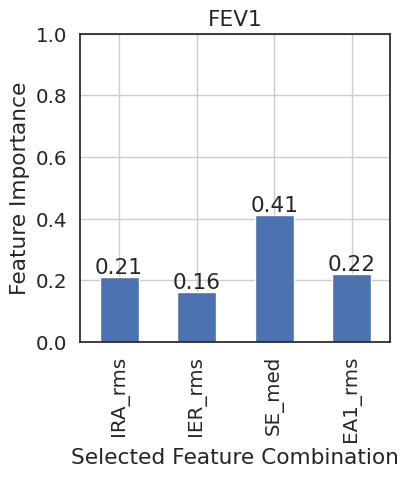

Percentage error =  31.71 %


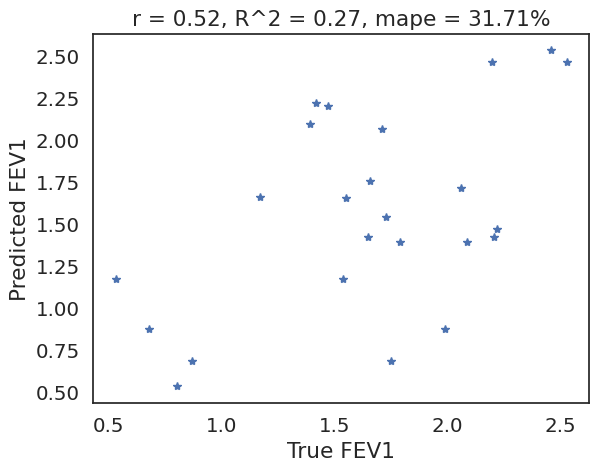

In [ ]:
performance_visualize(y_true_fev1,y_predicted_fev1,feat_importances_fev1,fev1_features,cols_N,'FEV1')

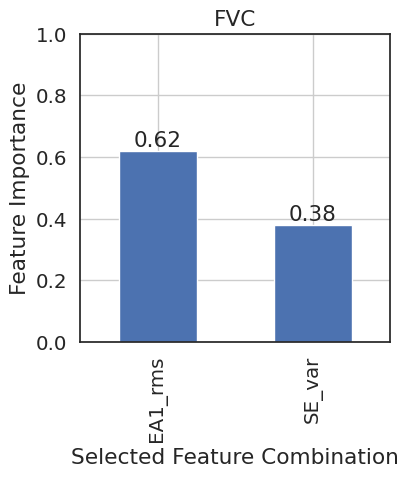

Percentage error =  21.12 %


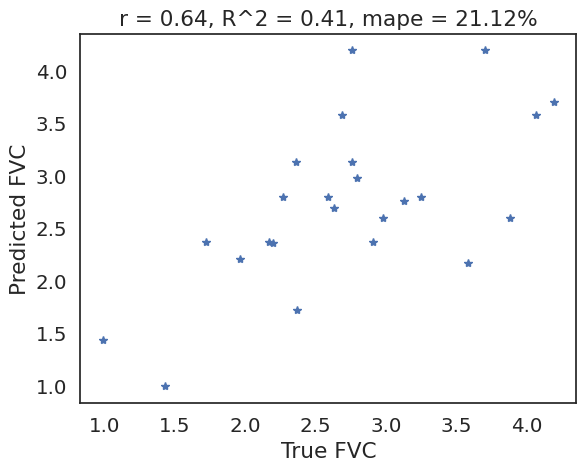

In [ ]:
performance_visualize(y_true_fvc,y_predicted_fvc,feat_importances_fvc,fvc_features,cols_N,'FVC')

# Soni - EDR

In [ ]:
# Define Data
x_test,y_test,y_test_fvc,y_test_bmi,y_test_subjects = EDR_soni,fev1_dhmc,fvc_dhmc,bmi_dhmc,subjects_left_dhmc
sq_pr1 = model_classifier_ecg_board.predict(data_normalize(x_test))
x_test_class = sq_pr1.round()

4/4 [==============================] - 1s 177ms/step


In [ ]:
# Get hand engineered features
x_test_handfeat = get_hand_features(x_test, x_test_class,y_test_bmi,Fs_resp)
x_test_handfeat = np.nan_to_num(x_test_handfeat,nan=0,posinf=None,neginf=None)
# Summarization step - per subject
x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,cols_N = summarize_features(x_test_handfeat)
print(x_test_feat_new.shape,y_test_class_new.shape,y_test_fvc_new.shape,y_test_bmi_new.shape,y_test_subjects_new.shape)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(24, 27) (24,) (24,) (24,) (24,)


## Visualize feature correlations

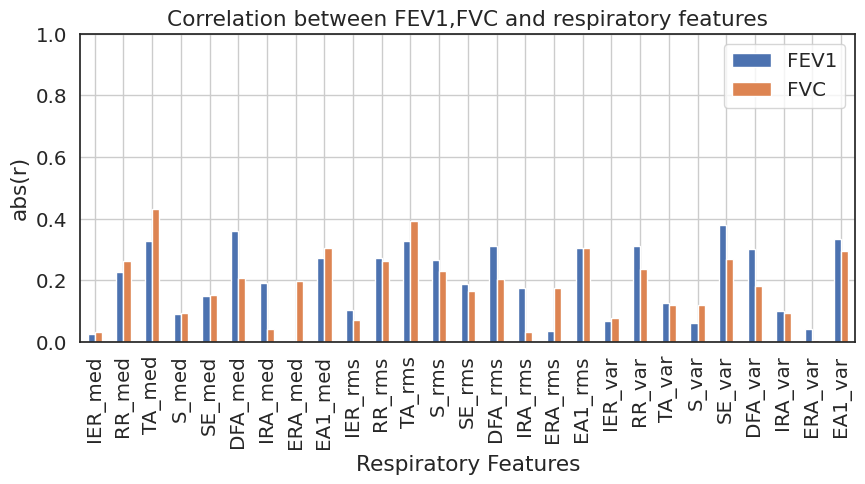

In [ ]:
fev1_fvc_correlation(x_test_feat_new,y_test_class_new,y_test_fvc_new)

## Model Selection

In [ ]:
fev1_features = feature_selection(x_test_feat_new,y_test_class_new,y_test_subjects_new)
fvc_features = feature_selection(x_test_feat_new,y_test_fvc_new,y_test_subjects_new)
print(fev1_features, fvc_features)

(3, 21) (18, 23, 21)


In [ ]:
print('FEV1 Feature Combination:', [cols_N[m] for m in fev1_features])
print('FVC Feature Combination:', [cols_N[m] for m in fvc_features])

FEV1 Feature Combination: ['S_med', 'S_var']
FVC Feature Combination: ['IER_var', 'DFA_var', 'S_var']


## Model Training and LOSO Evaluation

In [ ]:
# FEV1 Performance
y_true_fev1,y_predicted_fev1,feat_importances_fev1 = model_train_eval(x_test_feat_new,y_test_class_new,y_test_subjects_new,fev1_features)
# FVC Performance
y_true_fvc,y_predicted_fvc,feat_importances_fvc = model_train_eval(x_test_feat_new,y_test_fvc_new,y_test_subjects_new,fvc_features)

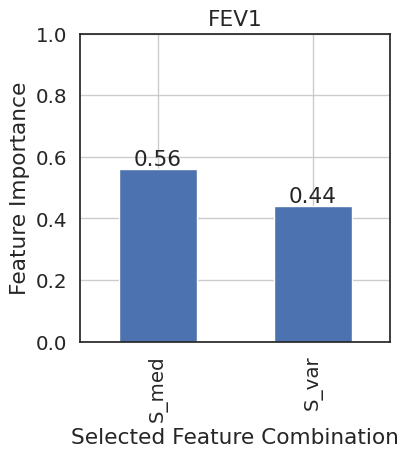

Percentage error =  31.57 %


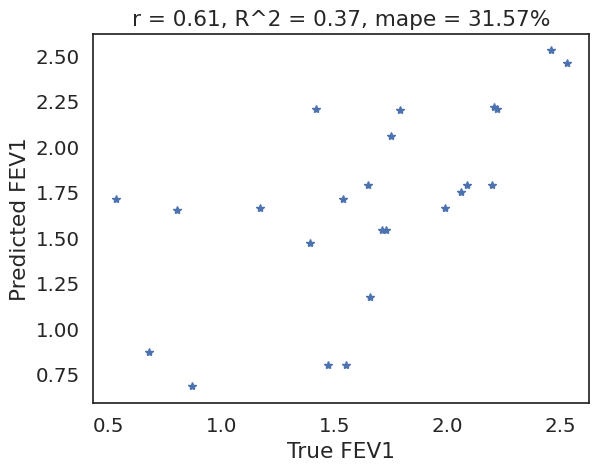

In [ ]:
performance_visualize(y_true_fev1,y_predicted_fev1,feat_importances_fev1,fev1_features,cols_N,'FEV1')

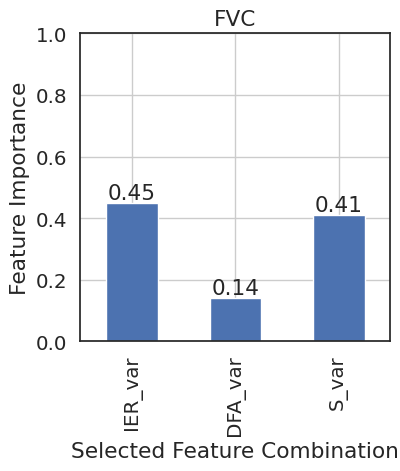

Percentage error =  22.07 %


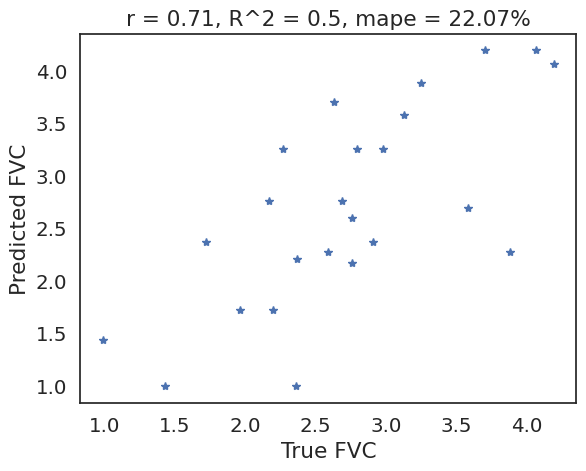

In [ ]:
performance_visualize(y_true_fvc,y_predicted_fvc,feat_importances_fvc,fvc_features,cols_N,'FVC')